# LiteBIRD cosmic ray simulator
This variational autoencoder generates timelines of the power measured by the LiteBIRD bolometers during the impact of cosmic rays, using a Gaussian model.
It is trained with data generated by a traditional cosmic ray simulator.

## License

In [ ]:
# litebird-cosmic-ray-simulator
# Copyright (C) 2020  Matteo Zeccoli Marazzini

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

## Modules
We need TensorFlow 2.3 and TensorFlow Probability 0.11.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
import scipy.stats
import scipy.signal

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

## Input data
To train the autoencoder, timestreams generated by a traditional cosmic ray simulator are used.

### Acquisition
The timestreams are stored in numpy arrays.
We read the files and store the data in a `(n_tods, 2, n_bolometers, n_timesteps)` array.

* The first dimension refers to the different samples.
* The second dimension refers to the time value (`[0]`) and the power value (`[1]`).
* The third dimension refers to the different bolometers.
* The fourth dimension refers to the different timesteps.

Since the timesteps are set beforehand (depending on the frequency of the sampling) and are the same in every timestream, they are not needed in the autoencoder.
The value of the power instead is what the autoencoder learns to predict.

In [2]:
# The number of input samples
n_tods = 1000
# The number of bolometers we want to use
# The max is 12 since data files contain 12 of them
n_bolometers = 12

# Load data into a (n_tods, 2, n_bolometers, n_timesteps) np array.
data = []
for i in range(1, n_tods+1):
    data.append(np.load(f"data/TOD_mc_{i:04}.npy")[:,:n_bolometers,:])
data = np.array(data)

# Store the timestep values in a (n_timesteps,) array.
# We won't need them to train the network.
timesteps = data[0, 0, 0]
n_timesteps = len(timesteps)

# Transform data to a (n_tods, n_timesteps, n_bolometers) np array.
# The axes get swapped because the convolutional network accepts input
#     in (timesteps, features) shape.
data = np.swapaxes(data, 2, 3)[:, 1]

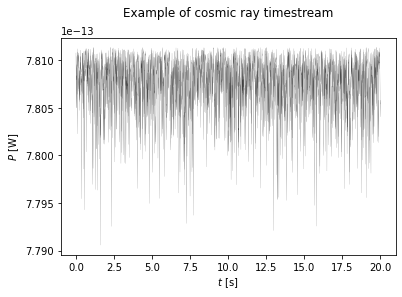

In [3]:
# Plot an example timestream.
plt.plot(timesteps, data[0, :, 0], color="k", linewidth=0.1);
plt.title("Example of cosmic ray timestream\n");
plt.xlabel("$t~[\mathrm{s}]$");
plt.ylabel("$P~[\mathrm{W}]$");
#plt.savefig("images/gauss/input.pdf");

### Normalization

In this Gaussian model, we normalize data within the $[-1, 1]$ range.

In [4]:
# Save the max, min and median of the data
max_data = np.max(data)
min_data = np.min(data)
median = np.median(data)
    
def normalize_data(data):
    return (data - median) / (max_data - min_data)

def denormalize_data(data):
    return data * (max_data - min_data) + median

# Save the normalized data
normalized_data = normalize_data(data)

In [5]:
print(np.max(normalized_data), np.min(normalized_data))

0.09910087957537399 -0.900899120424626


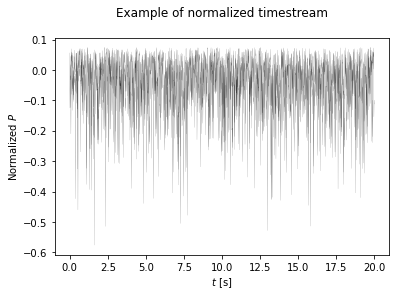

In [6]:
# Plot an example normalized timestream.
plt.plot(timesteps, normalized_data[0, :, 0], color="k", linewidth=0.1);
plt.title("Example of normalized timestream\n");
plt.xlabel("$t~[\mathrm{s}]$");
plt.ylabel("Normalized $P$");
#plt.savefig("images/gauss/normalized-input.pdf");

## The autoencoder
First of all, we define some constants that affect the neural network.

In [7]:
# The dimension of the latent space
latent_dim = 20
# The dimension of the convolutional kernel
kernel_size = 10
# The number of convolutional filters
n_filters = 64
# The number of dense units
n_units = 128
# The dropout rate
dropout_rate = 0.1

### The prior

We use a Gaussian prior $p_\vartheta(z) = \mathcal N(z; 0, 1)$.

In [8]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dim), scale=1),
                        reinterpreted_batch_ndims=1)

### The encoder
The encoder associates each data sample $x$ with an approximate posterior distribution $q_\varphi(z|x)$ on the latent parameters $z$.
The posterior is a `latent_dim`-dimensional Multivariate Gaussian $q_\varphi(z|x) = \mathcal N_\varphi(z; \mu(x), \Sigma(x))$ with symmetric $\Sigma$.
The `KLDivergenceRegularizer` adds the KL term to the loss function.

In [9]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=(n_timesteps, n_bolometers), name="encoder_input"),
    tfkl.Conv1D(n_filters, kernel_size, padding="same",
                  activation=tf.nn.leaky_relu, name="encoder_conv_1"),
    tfkl.MaxPooling1D(),
    tfkl.Dropout(dropout_rate),
    tfkl.Flatten(),
    tfkl.Dense(n_units, activation=tf.nn.leaky_relu, name="encoder_dense_2"),
    tfkl.Dropout(dropout_rate),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim),
               activation=None, name="encoder_dense_3"),
    tfpl.MultivariateNormalTriL(
        latent_dim,
    activity_regularizer=tfpl.KLDivergenceRegularizer(prior), name="encoder_output"),
], name="encoder")

In [10]:
# Show the encoder structure
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_conv_1 (Conv1D)      (None, 3126, 64)          7744      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1563, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1563, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100032)            0         
_________________________________________________________________
encoder_dense_2 (Dense)      (None, 128)               12804224  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
encoder_dense_3 (Dense)      (None, 230)               2967

### The decoder
The decoder associates with each latent parameter $z$ a likelihood distribution $p_\vartheta(x|z)$ on the data $x$.
The distribution is a Normal $p_\vartheta(x|z) = \mathcal N(x | \mu(z), \sigma(z))$.

In [11]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=(latent_dim), name="decoder_input"),
    tfkl.Dense(n_units, activation=tf.nn.leaky_relu, name="decoder_dense_1"),
    tfkl.Dropout(dropout_rate),
    tfkl.Dense(np.prod((n_timesteps//2, n_filters)), activation=tf.nn.leaky_relu, name="decoder_dense_2"),
    tfkl.Dropout(dropout_rate),
    tfkl.Reshape((n_timesteps//2, n_filters)),
    tfkl.Conv1DTranspose(n_filters, kernel_size, padding="same",
                                   strides=2, activation=tf.nn.leaky_relu, name="decoder_conv_transpose_1"),
    tfkl.Conv1D(filters=2*n_bolometers, kernel_size=kernel_size, strides=1,
                padding='same', activation=None, name="decoder_conv"),
    tfkl.Reshape((n_timesteps, n_bolometers, 2)),
    tfkl.Lambda(lambda t: tf.convert_to_tensor([tf.nn.relu(t[...,0])+1e-3, t[...,1]])),
    tfpl.DistributionLambda(
        make_distribution_fn=lambda t: tfd.Normal(loc=t[1],scale=t[0]),
        convert_to_tensor_fn=lambda s: s.sample())
], name="decoder")

In [12]:
# Show the decoder structure
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_dense_1 (Dense)      (None, 128)               2688      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
decoder_dense_2 (Dense)      (None, 100032)            12904128  
_________________________________________________________________
dropout_5 (Dropout)          (None, 100032)            0         
_________________________________________________________________
reshape (Reshape)            (None, 1563, 64)          0         
_________________________________________________________________
decoder_conv_transpose_1 (Co (None, 3126, 64)          41024     
_________________________________________________________________
decoder_conv (Conv1D)        (None, 3126, 24)          1538

### Connecting the encoder and the decoder

We create a custom Model class to define the training step of the network, adding to the metrics the likelihood $p_\vartheta(x|z)$, where $x$ is the input and $p_\vartheta(\cdot|z)$ is the learned distribution outputted by the decoder.

In [13]:
class VAEModel(tfk.Model):
    def train_step(self, x):
        with tf.GradientTape() as tape:
            likelihood = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(x, likelihood, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(x, likelihood)
        # Return a dict mapping metric names to current value
        return {"lik": likelihood.prob(x), **{m.name: m.result() for m in self.metrics}}


In [14]:
# Instantiate the model
vae = VAEModel(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

## Training
We are now ready to train the network.
We use the negative log-likelihood as loss function, as described in arXiv:1312.6114.

In [15]:
# The number of the epochs to train the network for
epochs = 50
learning_rate = 1e-3

negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
            loss=negloglik)

history = vae.fit(x=normalized_data[:800], y=None,
            epochs=epochs, validation_data=(normalized_data[800:], None), verbose=1,
            callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]).history

Epoch 1/40
25/25 [==============================] - 34s 1s/step - lik: 2.8045 - loss: 188.5455 - val_loss: 4.2309
Epoch 2/40
25/25 [==============================] - 37s 1s/step - lik: 1.6124 - loss: 3.8229 - val_loss: 2.7656
Epoch 3/40
25/25 [==============================] - 33s 1s/step - lik: 1.4579 - loss: 2.2800 - val_loss: 1.5384
Epoch 4/40
25/25 [==============================] - 32s 1s/step - lik: 1.4170 - loss: 1.3345 - val_loss: 0.7901
Epoch 5/40
25/25 [==============================] - 33s 1s/step - lik: 1.4227 - loss: 0.8736 - val_loss: 0.5293
Epoch 6/40
25/25 [==============================] - 32s 1s/step - lik: 1.4543 - loss: 0.5682 - val_loss: 0.2128
Epoch 7/40
25/25 [==============================] - 32s 1s/step - lik: 1.5159 - loss: 0.4789 - val_loss: 0.2993
Epoch 8/40
25/25 [==============================] - 32s 1s/step - lik: 1.5562 - loss: 0.3311 - val_loss: 0.1237
Epoch 9/40
25/25 [==============================] - 32s 1s/step - lik: 1.5985 - loss: 0.2204 - val_los

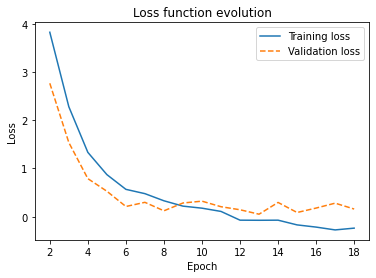

In [16]:
first_epoch = 1
plt.plot(list(range(first_epoch+1, len(history["loss"])+1)), history["loss"][first_epoch:],
         label="Training loss", linestyle="-")
plt.plot(list(range(first_epoch+1, len(history["loss"])+1)), history["val_loss"][first_epoch:],
         label="Validation loss", linestyle="--")
plt.title("Loss function evolution")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/gauss/loss.pdf");
plt.show();

## Results

### The encoder
A plot of the first two dimensions of the means of the postrior distributions corresponding to input data.

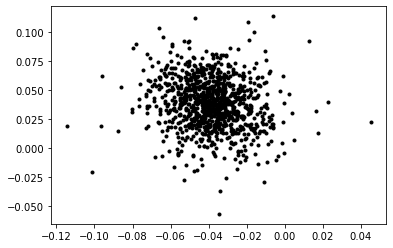

In [17]:
zs = encoder(normalized_data).mean().numpy()
plt.plot(zs[:,0], zs[:,1], ".k")
#plt.savefig("images/gauss/latent.pdf")
del zs

### The decoder

#### Example of simulated timeline

First of all, we plot a random output sample, feeding into the decoder a latent parameter generated with the prior.

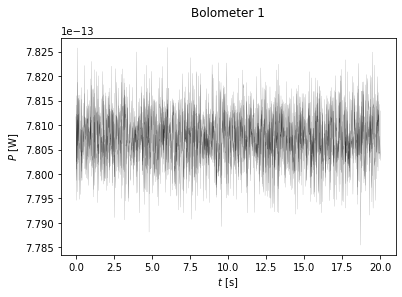

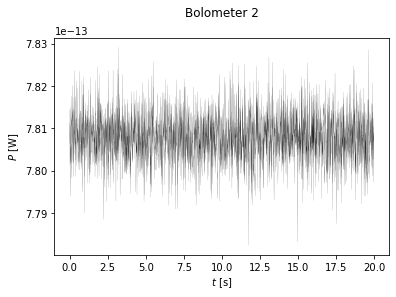

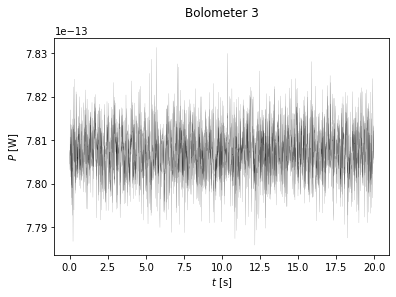

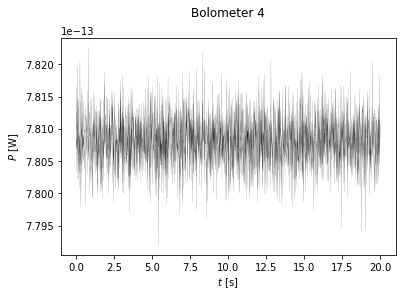

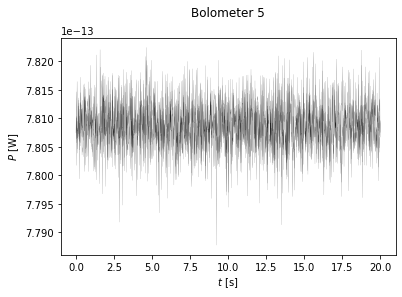

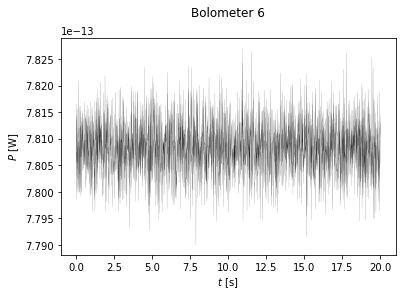

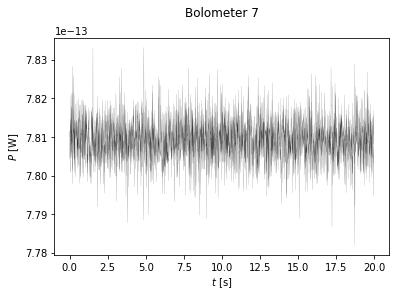

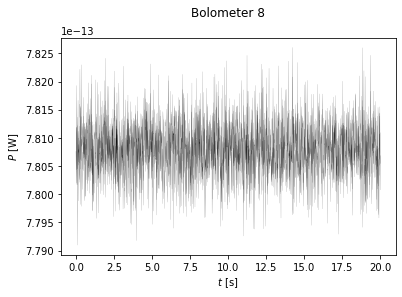

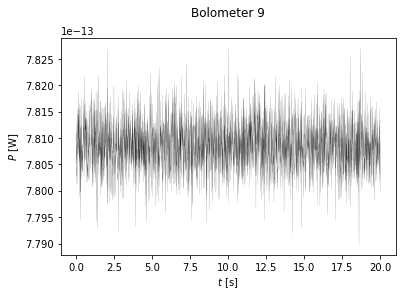

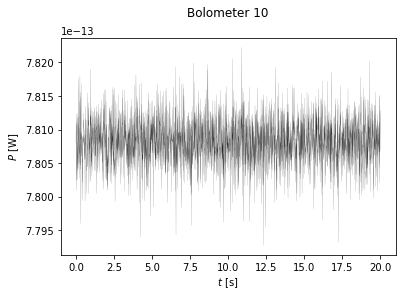

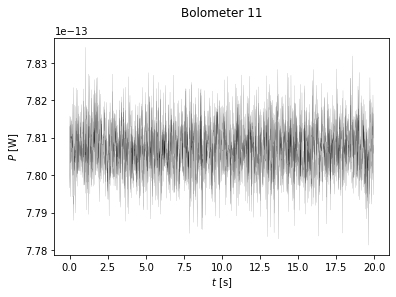

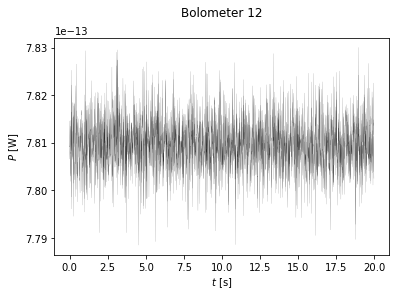

In [18]:
z = prior.sample(1)
xtilde = decoder(z)
x_decoded = denormalize_data(xtilde.sample().numpy()).reshape((n_timesteps, n_bolometers))
for i in range(n_bolometers):
    plt.plot(timesteps, x_decoded[:, i], color="k", linewidth=0.1);
    plt.title(f"Bolometer {i+1}\n")
    plt.xlabel("$t~[\mathrm{s}]$")
    plt.ylabel("$P~[\mathrm{W}]$")
    #plt.savefig(f"images/gauss/simulated-bolometer-{i+1}.pdf")
    plt.show();

Afterwards, we generate `n_simulated_tods` samples on which we will perform some tests.

In [19]:
n_simulated_tods = 100
z = prior.sample(n_simulated_tods)
xtilde = decoder(z)
simulated_data = denormalize_data(xtilde.sample().numpy())

#### Power distribution comparison

A first test is comparing the distribution of power values of the input and generated samples.

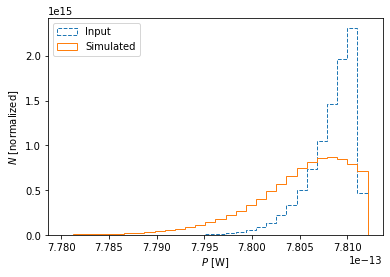

In [20]:
# Plot the power distribution of input samples
_, bins, _ = plt.hist(data.flatten(),
                      bins=30, density=True, histtype="step",
                      linestyle="--", label="Input");

# Plot the power distribution of generated samples
_, bins, _ = plt.hist(simulated_data.flatten(),
         bins=bins, density=True, histtype="step", linestyle="-",
         label="Simulated");

plt.legend(loc="upper left");
plt.title("Power distribution comparison\n")
plt.xlabel("$P~[\mathrm{W}]$")
plt.ylabel("$N~[\mathrm{normalized}]$");
#plt.savefig("images/gauss/power-distribution.pdf");
plt.show();

To do so, we calculate the Wasserstein distance $\mathrm{WD}_\text{hist}$ between the input and output power histograms.

In [21]:
wd = []
for _ in range(10000):
    wd.append(
        scipy.stats.wasserstein_distance(
            simulated_data[np.random.default_rng().integers(0, n_simulated_tods)].flatten(),
            data[np.random.default_rng().integers(0, n_tods)].flatten()))
    
wd_mean = np.mean(wd)
wd_std = np.std(wd)

print("WD:", wd_mean, "+-", wd_std)
del wd

WD_hist: 3.240848250628264e-16 +- 1.0009114821270445e-16


#### Power spectral density comparison

We then compare the power spectral density between input and output.

In [22]:
freq = n_timesteps / (timesteps[-1] - timesteps[0])

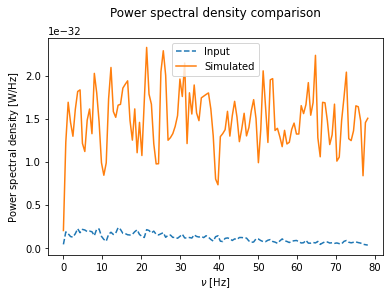

In [23]:
data_psd = scipy.signal.welch(data[0,:,0], fs=freq)
simulated_data_psd = scipy.signal.welch(simulated_data[0,:,0], fs=freq)

plt.plot(data_psd[0], data_psd[1], linestyle="--", label="Input")
plt.plot(simulated_data_psd[0], simulated_data_psd[1], linestyle="-", label="Simulated")
plt.title("Power spectral density comparison\n")
plt.xlabel("$\\nu~[\mathrm{Hz}]$")
plt.ylabel("Power spectral density $[\mathrm{W/Hz}]$")
plt.legend()
#plt.savefig("images/gauss/psd.pdf")
plt.plot();

We use the Wasserstein distance $\mathrm{WD}_\text{psd}$.

In [24]:
psd_wd = []
for _ in range(10000):
    i = np.random.default_rng().integers(0, n_tods)
    bolometer = np.random.default_rng().integers(0, n_bolometers)
    data_psd = scipy.signal.welch(data[i,:,bolometer], fs=freq)[1]
    
    i = np.random.default_rng().integers(0, n_simulated_tods)
    bolometer = np.random.default_rng().integers(0, n_bolometers)
    simulated_data_psd = scipy.signal.welch(simulated_data[i,:,bolometer], fs=freq)[1]
    
    psd_wd.append(scipy.stats.wasserstein_distance(data_psd, simulated_data_psd))
    
psd_wd_mean = np.mean(psd_wd)
psd_wd_std = np.std(psd_wd)

print("WD:", psd_wd_mean, "+-", psd_wd_std)
del psd_wd

WD_psd: 4.7023558017217676e-33 +- 2.9451382416688847e-33


#### Bolometer correlations

We then compare the correlation matrices of the input and the output bolometers.

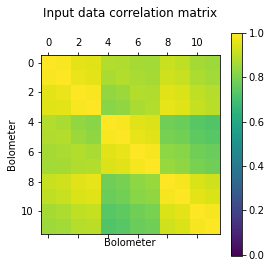

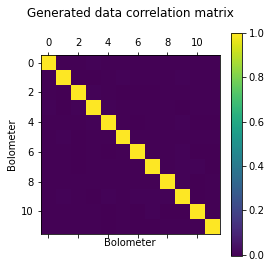

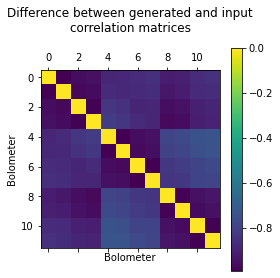

In [25]:
# Compute the correlation matrices between the bolometers
data_cor = []
for i in range(n_tods):
    data_cor.append(np.corrcoef(data[i], rowvar=False))
data_cor = np.mean(data_cor, axis=0)

simulated_data_cor = []
for i in range(n_simulated_tods):
    simulated_data_cor.append(np.corrcoef(simulated_data[i], rowvar=False))
simulated_data_cor = np.mean(simulated_data_cor, axis=0)

# Save max and min correlation to show the matrices on the same scale
min_cor = np.min((data_cor.min(), simulated_data_cor.min()))
max_cor = np.max((data_cor.max(), simulated_data_cor.max()))

# Input data correlation matrix
axes = plt.matshow(data_cor, vmin=min_cor, vmax=max_cor);
plt.colorbar(axes);
plt.title("Input data correlation matrix\n")
plt.xlabel("Bolometer")
plt.ylabel("Bolometer")
#plt.savefig("images/gauss/correlation-input.pdf");
plt.show();

# Generated data correlation matrix
axes = plt.matshow(simulated_data_cor, vmin=min_cor, vmax=max_cor);
plt.title("Generated data correlation matrix\n")
plt.colorbar(axes);
plt.xlabel("Bolometer")
plt.ylabel("Bolometer")
#plt.savefig("images/gauss/correlation-output.pdf");
plt.show();

# Difference between input and generated data correlation matrices
axes = plt.matshow(simulated_data_cor - data_cor);
plt.colorbar(axes);
plt.title("Difference between generated and input\ncorrelation matrices\n")
plt.xlabel("Bolometer")
plt.ylabel("Bolometer")
#plt.savefig("images/gauss/correlation-diff.pdf", bbox_inches="tight");
plt.show();

#### Pearson's correlation coefficient

We calculate the correlation coefficients between two input samples ($r_\text{in}$), two output samples ($r_\text{sim}$) and a input and a output sample ($r_\text{cross}$).

In [26]:
r_data = []
r_simulated = []
r_cross = []

for _ in range(10000):
    x = np.random.default_rng().integers(0, n_tods)
    y = np.random.default_rng().integers(0, n_tods)
    while x == y:
        y = np.random.default_rng().integers(0, n_tods)
    r_data.append(np.corrcoef(
        data[x].reshape(1, n_timesteps*n_bolometers),
        data[y].reshape(1, n_timesteps*n_bolometers))[0,1])

    x = np.random.default_rng().integers(0, n_simulated_tods)
    y = np.random.default_rng().integers(0, n_simulated_tods)
    while x == y:
        y = np.random.default_rng().integers(0, n_simulated_tods)
    r_simulated.append(np.corrcoef(
        simulated_data[x].reshape(1, n_timesteps*n_bolometers),
        simulated_data[y].reshape(1, n_timesteps*n_bolometers))[0,1])
    
    x = np.random.default_rng().integers(0, n_tods)
    y = np.random.default_rng().integers(0, n_simulated_tods)
    r_cross.append(np.corrcoef(
        data[x].reshape(1, n_timesteps*n_bolometers),
        simulated_data[y].reshape(1, n_timesteps*n_bolometers))[0,1])

r_data_mean = np.mean(r_data)
r_data_std = np.std(r_data)
r_simulated_mean = np.mean(r_simulated)
r_simulated_std = np.std(r_simulated)
r_cross_mean = np.mean(r_cross)
r_cross_std = np.std(r_cross)

In [27]:
print("r_in    =", r_data_mean, "+-", r_data_std)
print("r_sim   =", r_simulated_mean, "+-", r_simulated_std)
print("r_cross =", r_cross_mean, "+-", r_cross_std)

r_in    = 0.02965722711902573 +- 0.016897073735110197
r_sim   = 0.021797564993752322 +- 0.0059423737764548335
r_cross = 0.017346402740900855 +- 0.005233663362955451


### Performance

We estimate the time required to generate three years of cosmic ray timelines, in hours.

In [28]:
import time

ts = []
for i in range(1, 101, 5):
    t_0 = time.time()
    for _ in range(i):
        z = prior.sample(100)
        xtilde = decoder(z)
        x_decoded = denormalize_data(xtilde.sample().numpy())
    t_1 = time.time()
    ts.append(t_1-t_0)
    print(t_1-t_0)

1.0040459632873535
5.1142096519470215
9.346102476119995
13.704253435134888
18.301131010055542
22.293792963027954
26.238882064819336
29.495917081832886
33.048380851745605
37.09563064575195
41.38684844970703
45.04445815086365
60.420653104782104
55.261484146118164
64.07349061965942
164.35283041000366
141.7710371017456
69.64600396156311
278.30208921432495
108.25795125961304


Delta t = 14.338713480447616 +- 1.659488817198444


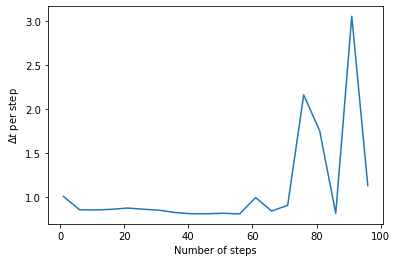

In [29]:
steps = np.arange(1, 101, 5)
plt.plot(steps, ts/steps)
plt.xlabel("Number of steps")
plt.ylabel("$\\Delta t$ per step")
print("Delta t =", np.mean(ts/steps)*3/(timesteps[-1]-timesteps[0])*365*24/100, "+-", end=" ")
print(np.std(ts/steps)*3/(timesteps[-1]-timesteps[0])*365*24/100 / np.sqrt(20))

## Loading and saving
If needed, we can save and load our trained network.
The lines are commented to prevent accidental data loss while executing the notebook.

In [30]:
#import pickle

In [31]:
#encoder.save_weights("models/gauss/encoder")
#decoder.save_weights("models/gauss/decoder")
#with open('models/gauss/history.pkl', 'wb') as f:
#    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)

In [15]:
#load_status = encoder.load_weights("models/gauss/encoder")
#load_status.assert_consumed()
#load_status = decoder.load_weights("models/gauss/decoder")
#load_status.assert_consumed()
#with open('models/gauss/history.pkl', 'rb') as f:
#    history = pickle.load(f)